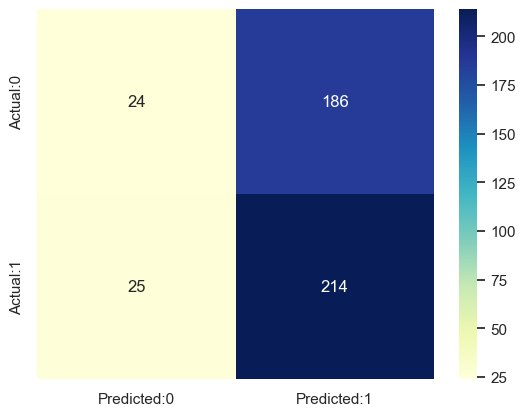

Logistic Regression Accuracy (default predictors): 53.01 %


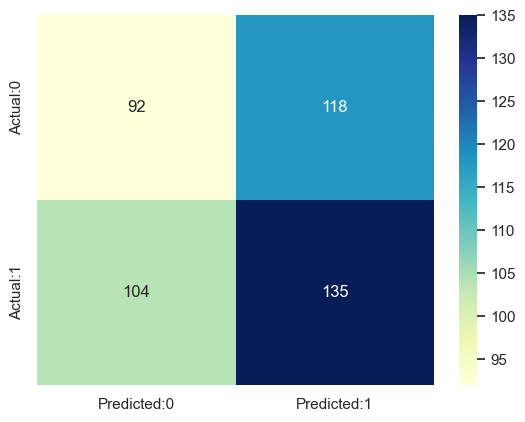

Random Forest Accuracy (default predictors): 50.56 %


In [1]:
import modelling

data = modelling.feature_stock_data('clean data/clean_data.csv')
modelling.logistic_regression_analysis(data)
modelling.random_forest_analysis(data)
